In [36]:
import numpy as np
import imutils
from matplotlib import pyplot as plt
import cv2
import itertools
import pandas as pd

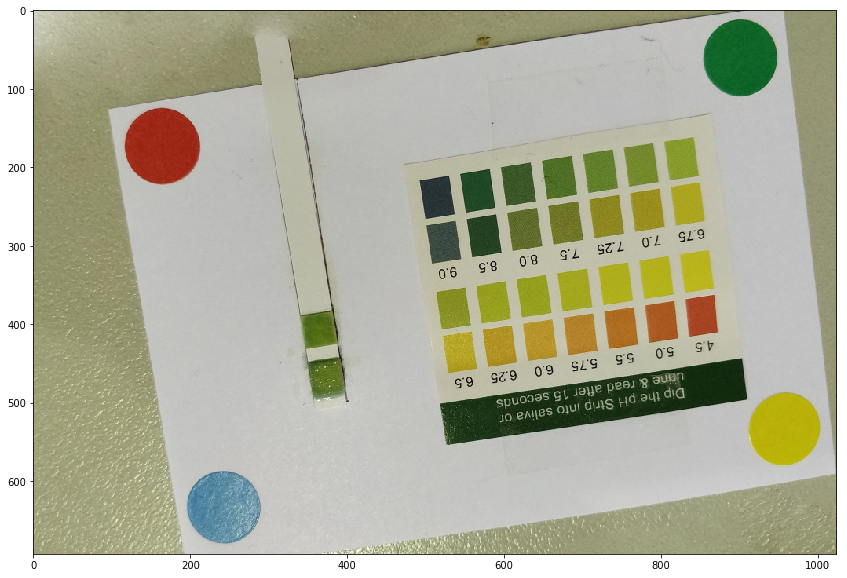

In [37]:
image = imutils.resize(cv2.imread('rotated.jpg'), width=1024)
plt.figure(figsize=(18,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [40]:
def find_circles(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    param1 = 1
    param2 = 100
    circles = None
    for i in range(10000):
        par1 = param1 + (i / 100)
        par2 = param2 - (i % 100)
        circles = cv2.HoughCircles(gray_image,cv2.HOUGH_GRADIENT,1,200,
                                param1=par1,param2=par2,minRadius=25,maxRadius=50)
        # print(circles.shape if circles is not None else "None")
        if (circles is not None) and circles.shape[1] == 4:
            break
    if not ((circles is not None) and circles.shape[1] == 4):
        print("Failed")
    
    circles = np.uint16(np.around(circles))
    return circles        

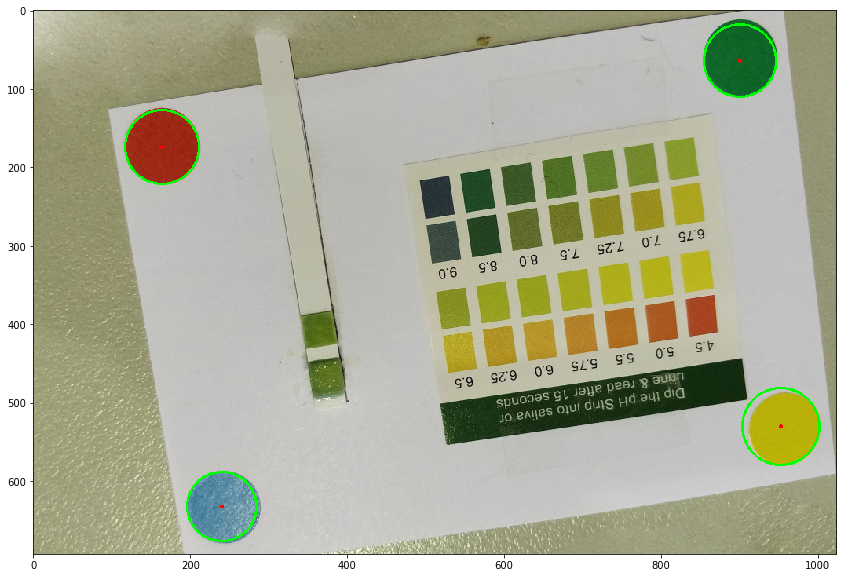

In [41]:
# Show circles

circles = find_circles(image)
circled = image.copy()
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(circled,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(circled,(i[0],i[1]),1,(0,0,255),2)

plt.figure(figsize=(18,10))
plt.imshow(cv2.cvtColor(circled, cv2.COLOR_BGR2RGB))
plt.show()

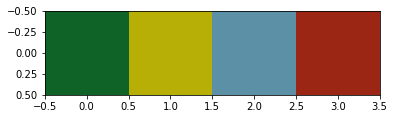

In [42]:
array2 = [[list(reversed(image[i[1], i[0]])) for i in circles[0,:]]]
array_match = np.array(array2)
plt.imshow(array_match)

In [43]:
def get_template():
    yellow = [255,255,0]
    blue = [65,105,225]
    green = [50,205,50]
    red = [255,0,0]
    return np.array([[yellow, blue, red, green]])

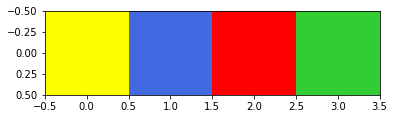

In [44]:
plt.imshow(get_template())

In [45]:
def color_dist(col_temp, col_match):
    return np.sum(np.abs(col_temp - col_match))       

def find_perm(array_match):
    array_template = get_template()
    perm_list = list(itertools.permutations([0,1,2,3]))
    distances_list = []
    for perm in perm_list:
        total_dist = 0
        for i in range(4):
            total_dist += color_dist(array_match[0][perm[i]], array_template[0][i])
        distances_list.append(total_dist)
    min_index = np.argmin(np.array(distances_list))
    perm = perm_list[min_index]
    return perm

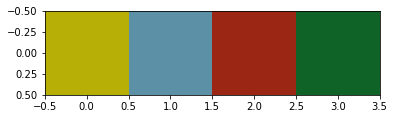

In [46]:
perm = find_perm(array_match)
plt.imshow([[array_match[0][perm[i]] for i in range(4)]])

In [47]:
def get_pos(coord):
    return (coord[0], coord[1])


def create_map(circles, perm):
    coords = [get_pos(circles[0,:][perm[i]]) for i in range(4)]
    return np.array(coords)


def crop_image(image, circles):
    array2 = [[list(reversed(image[i[1], i[0]])) for i in circles[0,:]]]
    array_match = np.array(array2)
    perm = find_perm(array_match)


    coords = create_map(circles, perm)

    positions = np.array([(0, 0), (1000, 0), (1000, 600), (0, 600)])
    h, status = cv2.findHomography(coords, positions)

    cropped = cv2.warpPerspective(image, h, (1000, 600))
    return cropped

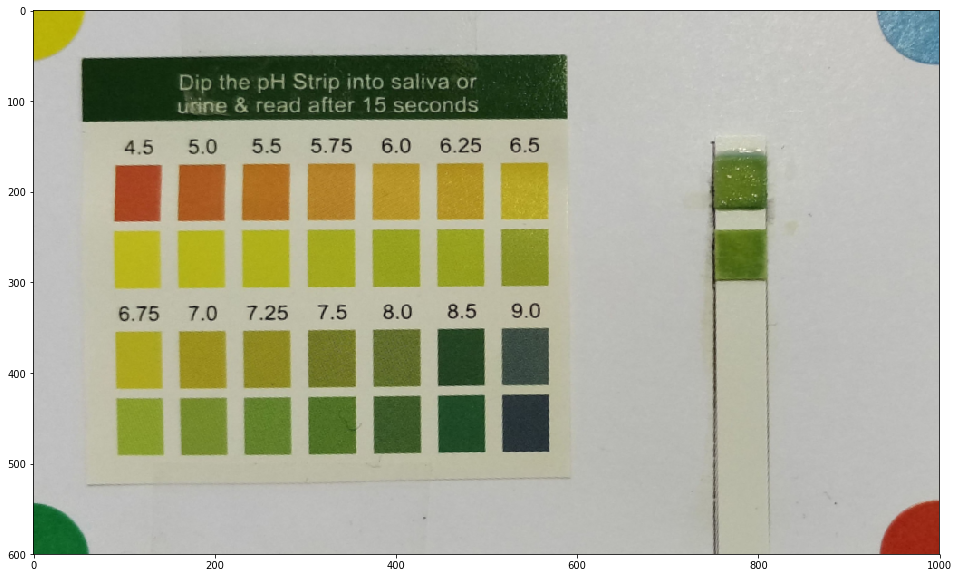

In [48]:
cropped = crop_image(image, circles)

plt.figure(figsize=(18,10))
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

In [49]:
def get_colors(img, X_pos, Y_pos):
    colors = []
    for i, y in enumerate(Y_pos):
        colors.append([])
        for x in X_pos:
            # take mean for +- 2 pixels
            mean_col = list(reversed(np.uint8(np.round(np.mean(img[y-2:y+2, x-2:x+2], axis=(0,1))))))
            colors[i].append(mean_col)
    return colors

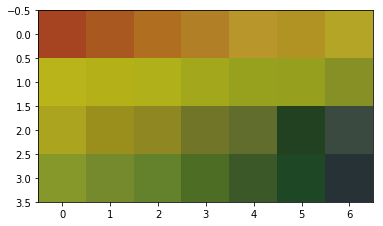

In [50]:
scale = get_colors(cropped, range(100, 600, 75), [200, 270, 380, 460])
plt.imshow(scale)

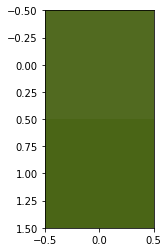

In [51]:
measurement = get_colors(cropped, [800], [200, 270])
plt.imshow(measurement)

In [52]:
def find_PH(scale, measurement):
    np_scale = np.array(scale)
    scale_1 = np.append(np_scale[0], np_scale[2]).reshape(1,14,3)
    scale_2 = np.append(np_scale[1], np_scale[3]).reshape(1,14,3)
    np_measurement = np.array(measurement)
    measurement_1 = np.array(np_measurement[0][0])
    measurement_2 = np.array(np_measurement[1][0])
    scale_1_dist = np.abs(scale_1 - measurement_1)
    scale_2_dist = np.abs(scale_2 - measurement_2)
    s1_dist_sum = [np.sum(x) for x in scale_1_dist[0]]
    s2_dist_sum = [np.sum(x) for x in scale_2_dist[0]]
    df = pd.DataFrame()
    df['Measurement_1'] = s1_dist_sum
    df['Measurement_2'] = s2_dist_sum
    df['Measurement_sum'] = df['Measurement_1'] + df['Measurement_2'] 
    df['pH'] = [4.5, 5.0, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 8.0, 8.5, 9.0]
    value = df.loc[df['Measurement_sum'] == df['Measurement_sum'].min(), 'pH'].iloc[0]
    return value

In [53]:
print(find_PH(scale, measurement))


7.5
